In [11]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
data_dir = 'kaggle-survey-2018/'

In [3]:
multiple_choice = pd.read_csv(data_dir + 'multipleChoiceResponses.csv', low_memory=False)

In [4]:
def convert_salary(salary):

    if salary == '500,000+':
        return 500000
    else:
        try:
            a, b = salary.replace(',','').split('-')
            avg = (int(a)*1000+int(b))/2
            return avg
        except:
            return None

In [5]:
def convert_xp(xp, return_type):
    if xp == '30 +':
        xp = 30
    elif xp == '40+ years':
        xp = 40
    elif xp == '< 1 year':
        xp = 0.5
    else:
        try:
            a, b = xp.replace(' years', '').split('-')
            xp = (int(a)+int(b))/2
        except:
            return None
        
    if return_type == 'years':
        return xp
    elif return_type == 'seniority level':
        if xp < 3:
            return 0
        elif xp < 6:
            return 1
        else:
            return 2
    else:
        return None   

In [6]:
def convert_age(age):
    if age == '80+':
        return 80
    else:
        try:
            a, b = age.split('-')
            return (int(a)+int(b))/2
        except:
            return None

In [7]:
df = pd.DataFrame()
df['gender'] = multiple_choice.Q1
df['current_role_xp'] = multiple_choice.Q8.apply(convert_xp, args = ('years',))
df['coding_xp'] = multiple_choice.Q24.apply(convert_xp, args = ('years',))
df['ml_xp'] = multiple_choice.Q25.apply(convert_xp, args = ('years',))
df['current_role_xp_level'] = multiple_choice.Q8.apply(convert_xp, args = ('seniority level',))
df['coding_xp_level'] = multiple_choice.Q24.apply(convert_xp, args = ('seniority level',))
df['ml_xp_level'] = multiple_choice.Q25.apply(convert_xp, args = ('seniority level',))
df['income'] = multiple_choice.Q9.apply(convert_salary)
df['geography'] = multiple_choice.Q3
df['original_age'] = multiple_choice.Q2
df['age'] = multiple_choice.Q2.apply(convert_age)

df = df[df.gender.isin(['Male', 'Female'])]

In [8]:
df_plot = df.groupby(by=['gender','age']).agg({'income':['mean', 'count']})
df_plot.columns = ['_'.join(col).strip() for col in df_plot.columns.values]
df_plot.reset_index(inplace=True)

df_plot = sqldf("""
with fl as (
    select *
    from df_plot
    where gender = 'Female'
    and income_count >= 50
)
, ml as (
    select *
    from df_plot
    where gender = 'Male'
    and income_count >= 50
)
, ages as (
    select distinct fl.age
    from fl
    join ml on fl.age = ml.age
)
select *
from fl
where age in (select * from ages)
UNION ALL
select *
from ml
where age in (select * from ages)
""")

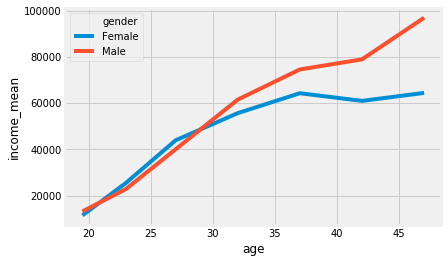

In [12]:
sns.lineplot(x = 'age', y='income_mean', hue='gender', data=df_plot)
plt.show()